<a href="https://colab.research.google.com/github/lucas-fpaiva/AnalisePred_I/blob/main/Projeto/car_eval/classifier_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Avaliar a popularidade de músicas de forro

In [25]:
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns

from scipy.io.arff import loadarff 
from scipy.io import arff

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC

from sklearn.metrics import precision_score as ps
from sklearn.metrics import recall_score as rs
from sklearn.metrics import f1_score as f1
from sklearn.metrics import accuracy_score as acs

from sklearn.metrics import plot_confusion_matrix

from sklearn.datasets import make_classification
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')


In [23]:
def grid_best_model (model="DT", names=False, grid=""):
  #A função retorna o modelo com os melhores parametros, os melhores parametros e o melhor score
  scoring = 'accuracy'

  if names == True:
    print("LM: LinearRegression\nKNN: KNeighborsClassifier\nMLPClassifier\nDT: DecisionTreeClassifier\nRF: RandomForestClassifier",
          "\nSVC: SupportVectorMachineClassifier\nBNB: BernoulliNaiveBayes\nADA: AdaBoostClassifier\nGB: GradientBoostingClassifier\n")
    
  if model == "DT":
    gs_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid['DT'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return DecisionTreeClassifier(**gs_cv.best_params_).fit(x_treino, y_treino), gs_cv.best_params_
      
  if model=="MLP":
    gs_cv = GridSearchCV(estimator=MLPClassifier(), param_grid=grid['MLP'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return MLPClassifier(**gs_cv.best_params_), gs_cv.best_params_
    
  if model == "RF":
    gs_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid['RF'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return RandomForestClassifier(**gs_cv.best_params_), gs_cv.best_params_

  if model == "KNN":
    gs_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=grid['KNN'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return KNeighborsClassifier(**gs_cv.best_params_), gs_cv.best_params_

  if model == "LM":
    gs_cv = GridSearchCV(estimator=LogisticRegression(), param_grid=grid['LM'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return LogisticRegression(**gs_cv.best_params_), gs_cv.best_params_

  if model == "BNB":
    gs_cv = GridSearchCV(estimator=BernoulliNB(), param_grid=grid['BNB'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return BernoulliNB(**gs_cv.best_params_).fit(x_treino, y_treino), gs_cv.best_params_

  if model == "SVC":
    gs_cv = GridSearchCV(estimator=SVC(), param_grid=grid['SVC'], cv= 5, scoring=scoring, n_jobs=-1)
    gs_cv.fit(x_treino, y_treino)
    return SVC(**gs_cv.best_params_).fit(x_treino, y_treino), gs_cv.best_params_
        
  return print("LM: LinearRegression\nKNN: KNeighborsClassifier\nMLPClassifier\nDT: DecisionTreeClassifier\nRF: RandomForestClassifier",
              "\nSVC: SupportVectorMachineClassifier\nBNB: BernoulliNaiveBayes\nADA: AdaBoostClassifier\nGB: GradientBoostingClassifier\n")
  
#Parâmetros do Grid
grid = {
    'RF':{ 
        'n_estimators': range(5,30,2),
        'max_depth' : range(5,30,2),
        'criterion' :['gini', 'entropy'],
        'random_state' : [0]},

    'MLP':{
        'hidden_layer_sizes': range(5,30,2),#[(10,), (15,), (20,), (30,)],
        'max_iter': [200],
        'activation' : ['relu', 'tanh'],
        'random_state' : [0]},

    'DT':{
        'max_depth': range(5,30,2),
        'min_samples_leaf': [1,2,3,4,5],
        'criterion' :['gini', 'entropy'],
        'random_state' : [0]},

    'KNN':{
        'n_neighbors': range(5,30,2),
        'weights': ['uniform', 'distance'],
        'metric' : ['manhattan', 'euclidean']},

    'LM':{
        'fit_intercept' : [True, False],
        'random_state' : [0]},

    'BNB':{
        'alpha' : np.arange(0.0, 1.0, 0.1)},
    
    'SVC':{
        'kernel' : ['linear', 'rbf'],
        'max_iter' : [-1, 1, 2],
        'class_weight' : ['None', 'balanced'],
        'random_state' : [0]}
}

In [4]:
def data_k_fold(data, k, tag, id_tag, features):
    kf=StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
    kf.get_n_splits(data[tag].values)
    ids = np.array(data[id_tag])
    folds = pd.DataFrame([], columns=[id_tag, 'fold'])
    k=1
    
    for train_index, test_index in kf.split(data[features], data[tag]):
      fold = np.array([k]*len(test_index))
      folds = pd.concat([folds, pd.DataFrame(np.transpose([ids[test_index],fold]),columns=[id_tag, 'fold'])])
      k+=1

    data = data.merge(folds, how='left',on=id_tag)   
    return data

In [5]:
def metrics (y_true, y_pred):
  return [acs(y_true, y_pred), ps(y_true, y_pred, average = 'weighted'), 
          f1(y_true, y_pred, average = 'weighted'), rs(y_true, y_pred, average = 'weighted')]

## Lendo o Dataset

In [11]:
!git clone 'https://github.com/lucas-fpaiva/AnalisePred_I.git'

Cloning into 'AnalisePred_I'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 182 (delta 12), reused 0 (delta 0), pack-reused 148
Receiving objects: 100% (182/182), 5.33 MiB | 17.66 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [12]:
data = loadarff('/content/AnalisePred_I/Projeto/car_eval/car-evaluation.arff')
data = pd.DataFrame(data[0])

# Convertendo os valores em bytes para int
for col in data.columns:
    data[col] = data[col].astype(int)

data['id'] = data.index
features = data.columns[1:-1]
data = data_k_fold(data, 5, 'class', 'id', features)


In [ ]:
data.to_csv("data_processed.csv")

In [13]:
data = pd.read_csv('https://raw.githubusercontent.com/lucas-fpaiva/AnalisePred_I/main/Projeto/car_eval/data_processed.csv', index_col=0)
features = data.columns[1:-1]

In [7]:
data.head()

,class,buying_price_vhigh,buying_price_high,buying_price_med,buying_price_low,maintenance_price_vhigh,maintenance_price_high,maintenance_price_med,maintenance_price_low,doors_2,...,persons_4,persons_more,luggage_boot_size_small,luggage_boot_size_med,luggage_boot_size_big,safety_low,safety_med,safety_high,id,fold
0,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,1,0,0,0,5
1,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,1,0,1,5
2,0,1,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,2,5
3,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,1,0,0,3,4
4,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,4,2


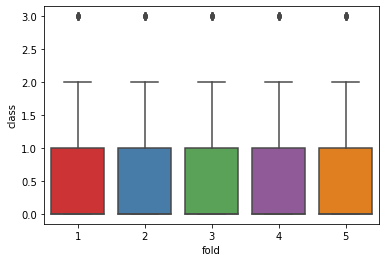

In [8]:
sns.boxplot(data = data, y='class',x='fold',palette='Set1')

## Avaliando a Árvore de Decisão

Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 1 [0.8815028901734104, 0.8749685850716261, 0.872208430917565, 0.8815028901734104]


<Figure size 432x288 with 0 Axes>

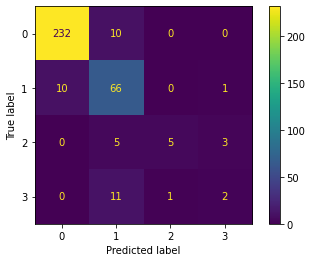

Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 2 [0.9161849710982659, 0.9188381726141418, 0.9129899548974694, 0.9161849710982659]


<Figure size 432x288 with 0 Axes>

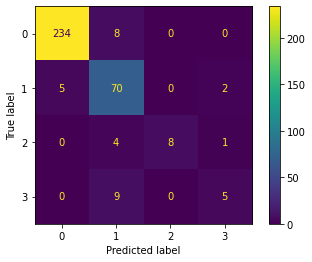

Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 3 [0.8786127167630058, 0.8830473182671598, 0.8774770215080528, 0.8786127167630058]


<Figure size 432x288 with 0 Axes>

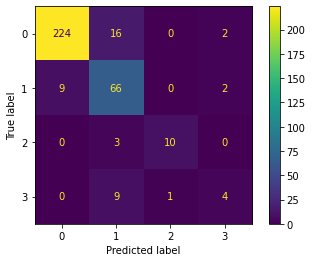

Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 4 [0.9014492753623189, 0.9017523917779671, 0.8995234144992598, 0.9014492753623189]


<Figure size 432x288 with 0 Axes>

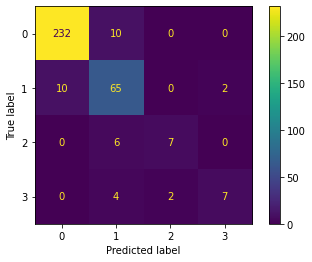

Modelo: LM
Melhor parametro: {'fit_intercept': False, 'random_state': 0}
Fold 5 [0.8956521739130435, 0.9033692555431685, 0.8932749506948043, 0.8956521739130435]


<Figure size 432x288 with 0 Axes>

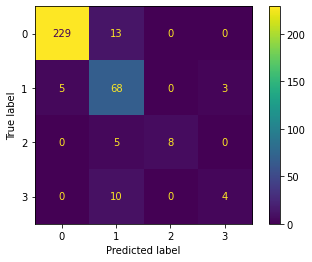

Modelo: KNN
Melhor parametro: {'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'uniform'}
Fold 1 [0.6965317919075145, 0.48858172070034345, 0.5743124144518518, 0.6965317919075145]


<Figure size 432x288 with 0 Axes>

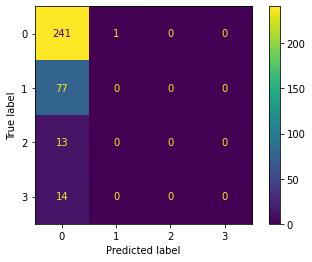

Modelo: KNN
Melhor parametro: {'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'uniform'}
Fold 2 [0.6907514450867052, 0.4873523315188999, 0.5714935032854108, 0.6907514450867052]


<Figure size 432x288 with 0 Axes>

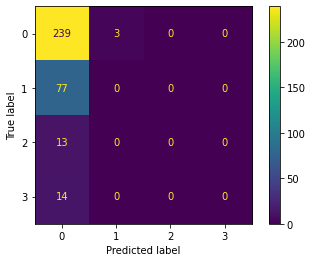

Modelo: KNN
Melhor parametro: {'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'uniform'}
Fold 3 [0.6820809248554913, 0.48548112886773204, 0.567228810360924, 0.6820809248554913]


<Figure size 432x288 with 0 Axes>

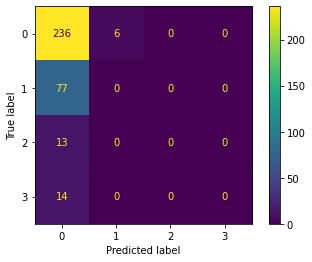

Modelo: KNN
Melhor parametro: {'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'uniform'}
Fold 4 [0.6985507246376812, 0.4914223120997641, 0.5769599841717367, 0.6985507246376812]


<Figure size 432x288 with 0 Axes>

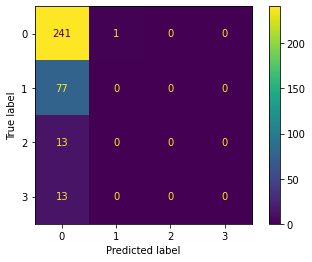

Modelo: KNN
Melhor parametro: {'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'uniform'}
Fold 5 [0.6869565217391305, 0.4889514066496164, 0.5712834304497236, 0.6869565217391305]


<Figure size 432x288 with 0 Axes>

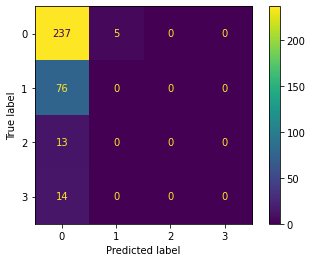

Modelo: MLP
Melhor parametro: {'activation': 'tanh', 'hidden_layer_sizes': 23, 'max_iter': 200, 'random_state': 0}
Fold 1 [0.9335260115606936, 0.9487647729890758, 0.9238880257000883, 0.9335260115606936]


<Figure size 432x288 with 0 Axes>

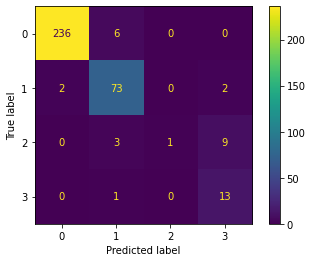

Modelo: MLP
Melhor parametro: {'activation': 'tanh', 'hidden_layer_sizes': 29, 'max_iter': 200, 'random_state': 0}
Fold 2 [0.9046242774566474, 0.8726522533557873, 0.8883070862235819, 0.9046242774566474]


<Figure size 432x288 with 0 Axes>

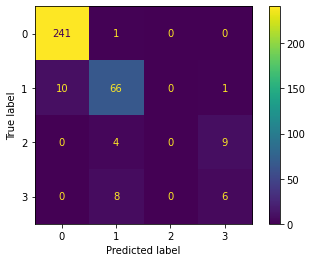

Modelo: MLP
Melhor parametro: {'activation': 'tanh', 'hidden_layer_sizes': 17, 'max_iter': 200, 'random_state': 0}
Fold 3 [0.8901734104046243, 0.8852609108908253, 0.8817896137260298, 0.8901734104046243]


<Figure size 432x288 with 0 Axes>

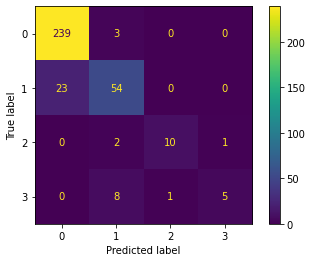

Modelo: MLP
Melhor parametro: {'activation': 'tanh', 'hidden_layer_sizes': 5, 'max_iter': 200, 'random_state': 0}
Fold 4 [0.855072463768116, 0.7964448423880126, 0.824271466417329, 0.855072463768116]


<Figure size 432x288 with 0 Axes>

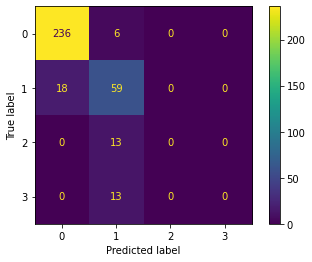

Modelo: MLP
Melhor parametro: {'activation': 'tanh', 'hidden_layer_sizes': 17, 'max_iter': 200, 'random_state': 0}
Fold 5 [0.9159420289855073, 0.8848478499826028, 0.8982976114574195, 0.9159420289855073]


<Figure size 432x288 with 0 Axes>

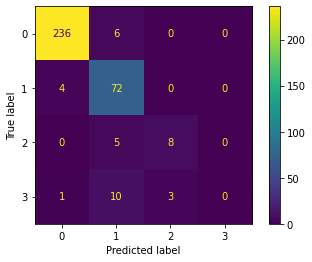

Modelo: DT
Melhor parametro: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 3, 'random_state': 0}
Fold 1 [0.9710982658959537, 0.9696943773094232, 0.9672054704725583, 0.9710982658959537]


<Figure size 432x288 with 0 Axes>

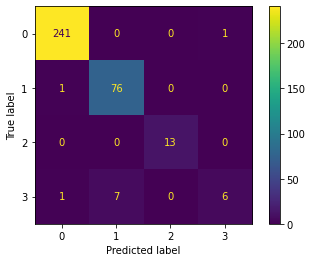

Modelo: DT
Melhor parametro: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'random_state': 0}
Fold 2 [0.9855491329479769, 0.9870792247534851, 0.9858988783604891, 0.9855491329479769]


<Figure size 432x288 with 0 Axes>

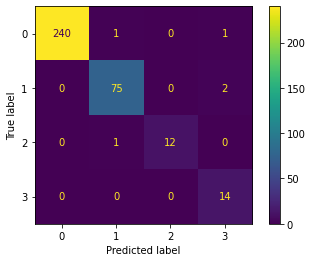

Modelo: DT
Melhor parametro: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 3, 'random_state': 0}
Fold 3 [0.9566473988439307, 0.9557157607855558, 0.9557197165903439, 0.9566473988439307]


<Figure size 432x288 with 0 Axes>

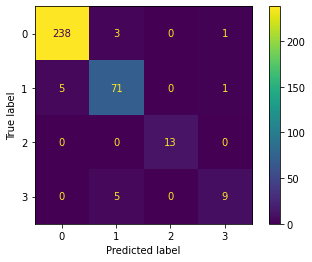

Modelo: DT
Melhor parametro: {'criterion': 'gini', 'max_depth': 13, 'min_samples_leaf': 1, 'random_state': 0}
Fold 4 [0.9768115942028985, 0.977178499357916, 0.9768442958008177, 0.9768115942028985]


<Figure size 432x288 with 0 Axes>

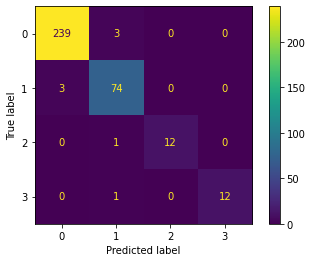

Modelo: DT
Melhor parametro: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_leaf': 1, 'random_state': 0}
Fold 5 [0.9797101449275363, 0.9797101449275363, 0.9797101449275363, 0.9797101449275363]


<Figure size 432x288 with 0 Axes>

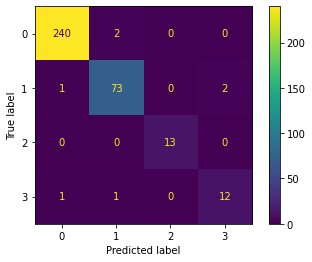

Modelo: RF
Melhor parametro: {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 9, 'random_state': 0}
Fold 1 [0.930635838150289, 0.9283710361448304, 0.9291375930348577, 0.930635838150289]


<Figure size 432x288 with 0 Axes>

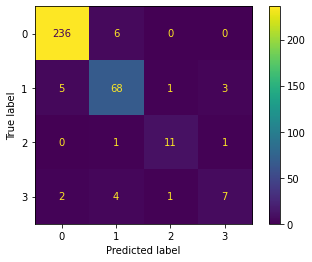

Modelo: RF
Melhor parametro: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 21, 'random_state': 0}
Fold 2 [0.9682080924855492, 0.9699421965317919, 0.9687665449742108, 0.9682080924855492]


<Figure size 432x288 with 0 Axes>

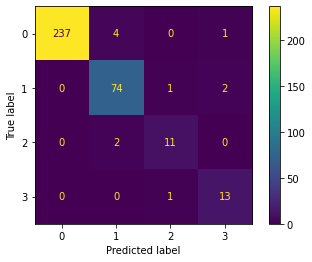

Modelo: RF
Melhor parametro: {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 7, 'random_state': 0}
Fold 3 [0.9450867052023122, 0.9448877100881035, 0.9448851735307239, 0.9450867052023122]


<Figure size 432x288 with 0 Axes>

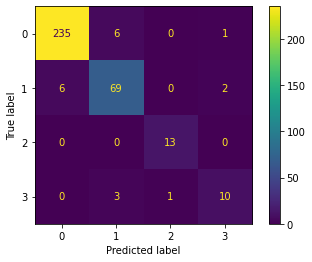

Modelo: RF
Melhor parametro: {'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 11, 'random_state': 0}
Fold 4 [0.9565217391304348, 0.959295352104636, 0.9544492251073716, 0.9565217391304348]


<Figure size 432x288 with 0 Axes>

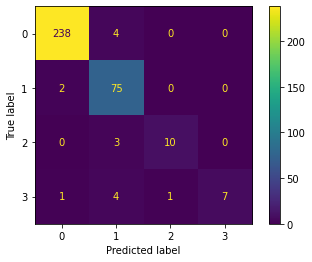

Modelo: RF
Melhor parametro: {'criterion': 'entropy', 'max_depth': 13, 'n_estimators': 13, 'random_state': 0}
Fold 5 [0.9594202898550724, 0.9612653777163992, 0.9591968096955723, 0.9594202898550724]


<Figure size 432x288 with 0 Axes>

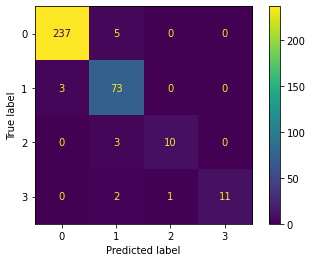

Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 1 [0.869942196531792, 0.888670520231214, 0.8682758520005244, 0.869942196531792]


<Figure size 432x288 with 0 Axes>

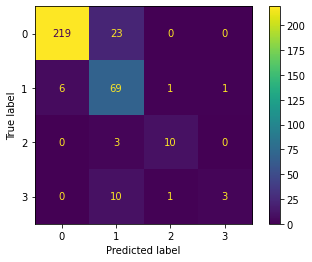

Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 2 [0.8526011560693642, 0.8761802344921347, 0.8587319615828404, 0.8526011560693642]


<Figure size 432x288 with 0 Axes>

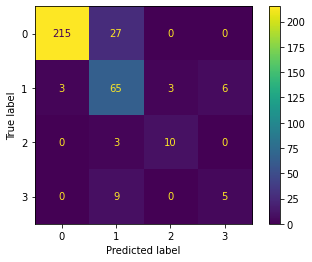

Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 3 [0.8526011560693642, 0.8696749983761857, 0.8554359356659919, 0.8526011560693642]


<Figure size 432x288 with 0 Axes>

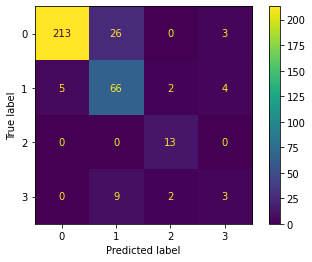

Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 4 [0.8753623188405797, 0.887146412685667, 0.8789431165886016, 0.8753623188405797]


<Figure size 432x288 with 0 Axes>

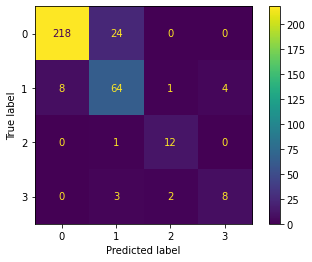

Modelo: BNB
Melhor parametro: {'alpha': 0.0}
Fold 5 [0.8695652173913043, 0.8907900265557848, 0.8745630588300615, 0.8695652173913043]


<Figure size 432x288 with 0 Axes>

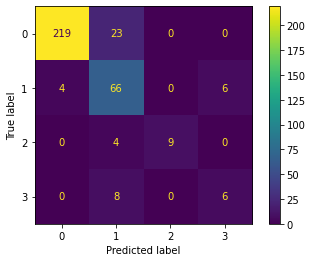

Modelo: SVC
Melhor parametro: {'class_weight': 'balanced', 'kernel': 'linear', 'max_iter': -1, 'random_state': 0}
Fold 1 [0.9450867052023122, 0.9523910720357506, 0.9467839554937164, 0.9450867052023122]


<Figure size 432x288 with 0 Axes>

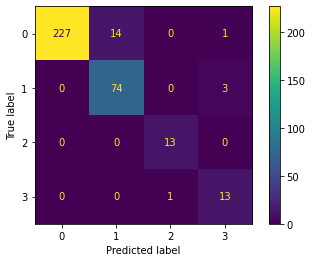

Modelo: SVC
Melhor parametro: {'class_weight': 'balanced', 'kernel': 'linear', 'max_iter': -1, 'random_state': 0}
Fold 2 [0.9132947976878613, 0.929850300587802, 0.917646133920607, 0.9132947976878613]


<Figure size 432x288 with 0 Axes>

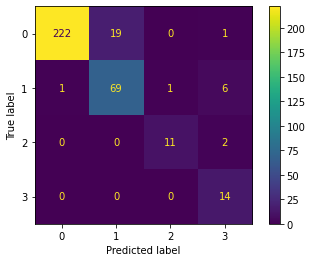

Modelo: SVC
Melhor parametro: {'class_weight': 'balanced', 'kernel': 'linear', 'max_iter': -1, 'random_state': 0}
Fold 3 [0.9075144508670521, 0.920257618046007, 0.9106273193386623, 0.9075144508670521]


<Figure size 432x288 with 0 Axes>

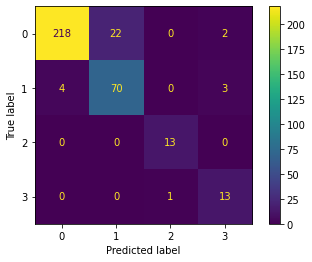

Modelo: SVC
Melhor parametro: {'class_weight': 'balanced', 'kernel': 'linear', 'max_iter': -1, 'random_state': 0}
Fold 4 [0.9159420289855073, 0.9344710247422259, 0.9194890529192369, 0.9159420289855073]


<Figure size 432x288 with 0 Axes>

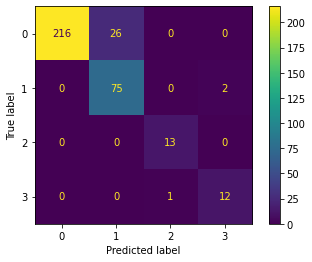

Modelo: SVC
Melhor parametro: {'class_weight': 'balanced', 'kernel': 'linear', 'max_iter': -1, 'random_state': 0}
Fold 5 [0.9217391304347826, 0.937209550289937, 0.9252549754221995, 0.9217391304347826]


<Figure size 432x288 with 0 Axes>

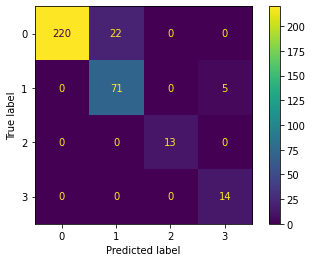

In [24]:
data_results = pd.DataFrame([],columns=['accuracy', 'precision', 'f1_score','recall', 'fold','model','parameters'])
models = ["LM", "KNN", "MLP", "DT", "RF", "BNB", "SVC"]

for name_model in models:
  results = []
  for k in range(1,6):
    treino = data[data.fold!=k]
    teste  = data[data.fold==k]
    
    x_treino = treino[features]
    y_treino = treino['class']

    x_teste = teste[features]
    y_teste = teste['class']

    model, best_parameters = grid_best_model(model=name_model, grid=grid)
    model.fit(x_treino, y_treino)
    y_pred= model.predict(x_teste)

    print("Modelo:", name_model)
    print("Melhor parametro:", best_parameters)         
    print("Fold", k, metrics(y_teste.values, y_pred))

    plt.figure()
    plot_confusion_matrix(model, x_teste, y_teste)
    plt.show()


    result = metrics(y_teste, y_pred)
    result.append(k)
    result.append(name_model)
    result.append(best_parameters)
    
    results.append(result)
        
  data_results = pd.concat([data_results, pd.DataFrame(results,columns=['accuracy', 'precision', 'f1_score','recall', 'fold','model','parameters'])])
  data_results.to_csv('/content/drive/MyDrive/AnalisePred_I/Car_results_'+ name_model + '.csv')


In [26]:
data_results.mean()

accuracy     0.885170
precision    0.858043
f1_score     0.866025
recall       0.885170
fold         3.000000
dtype: float64

### Predição do Modelo

In [27]:
model.fit(x_treino, y_treino)
np.sqrt(model.score(x_treino, y_treino))

0.9631684276912472

In [28]:
model.score(x_teste, y_teste)

0.9217391304347826

In [29]:
y_pred_t = model.predict(x_treino)

In [30]:
y_pred= model.predict(x_teste)

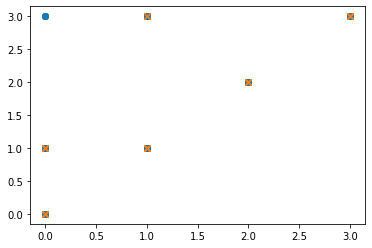

In [31]:
plt.plot(y_treino, y_pred_t, 'o')

plt.plot(y_teste, y_pred, 'x')


#### MAPE

In [ ]:
mape(y_teste,y_pred)*100

nan

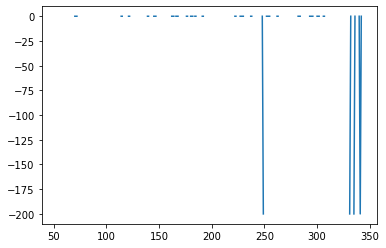

In [32]:
plt.plot(((y_teste.values - y_pred)/y_teste.values)*100)
np.mean(100*np.abs(y_teste.values - y_pred)/y_teste.values)

#### Plot do Modelo Teste x Treino

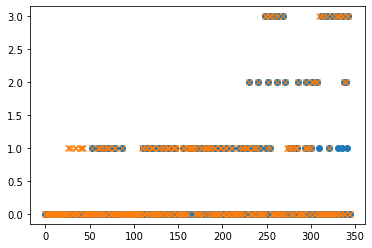

In [34]:
plt.plot(y_teste.values, 'o')
plt.plot(y_pred, 'x')

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true+0.00001))) * 100

In [ ]:
def mae (y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
def r2_score(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))